In [1]:
import sys, h5py, pdb,time, glob,os 
from importlib import reload
import pylab as pl, numpy as np
from numpy import log10 as log
from astropy import units as un, constants as cons
import scipy, scipy.stats
from matplotlib import ticker, patches
from mpl_toolkits.mplot3d import Axes3D
sys.path.append('/mnt/home/jstern/gizmo_analysis/pysrc')

In [2]:
import workdirs as wd
import FIRE_files as ff
from FIRE_files import cosmo, u
from projectPlotBasics import *
import first_pass as l
cmap = pl.get_cmap('viridis')
figdir = wd.basedir+'figures/'

Behroozi+18 not loaded
palettable colormaps are not installed
don't have phil's colormaps


In [3]:
CF_path = '../../../cooling_flow/pysrc'
sys.path.append(CF_path)
import cooling_flow as CF, HaloPotential as Halo
%matplotlib inline

In [4]:
simname = 'vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e4_n10_NoLowCool_tracking'
vc = 200. *un.km/un.s
Rcirc = 10.*un.kpc
simdir = wd.simdir+'/%s/output/'%simname
npz_fn = wd.tracksdir+simname+'/particle_tracks.npz'

In [5]:
sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=10,pr=False,
              analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
sim.z = 0 #for cooling function
print(sim.galaxyname, sim.Nsnapshots())

vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e4_n10_NoLowCool_tracking 325


In [6]:
snapNumbers = range(100,325,1)
ts = 3250-np.arange(len(snapNumbers))*10

In [7]:
snapshots = [sim.getSnapshot(i) for i in snapNumbers][::-1]

In [7]:
qs = [snapshot.dic[('PartType0','ParticleIDs')] for snapshot in u.Progress(snapshots)]

progress:  99% 37 seconds passed



In [8]:
ps = [snapshot.dic[('PartType4','ParticleIDs')] for snapshot in u.Progress(snapshots)]

progress:  99% 7 seconds passed



In [9]:
# select by accretion time
# Rs_func = lambda s: (s.coords()[:,:2]**2).sum(axis=1)**0.5
# _,inds1,inds2 = np.intersect1d(qs[0],qs[1],assume_unique=True,return_indices=True)
# accreted_inds = (  ((Rs_func(snapshots[0])<10) & (np.abs(snapshots[0].coords()[:,2])<1))[inds1] &
#                  (~((Rs_func(snapshots[1])<10) & (np.abs(snapshots[1].coords()[:,2]<1)))[inds2]) )
# accreted_IDs = qs[0][inds1][accreted_inds]

In [10]:
# select by location in CGM
tmp = np.concatenate([qs[0],ps[0]]) 
_,inds1,inds2 = np.intersect1d(tmp,qs[-1],assume_unique=True,return_indices=True)
accreted_inds = ((snapshots[-1].rs()<41) & (snapshots[-1].rs()>40))[inds2]
accreted_IDs = tmp[inds1][accreted_inds]

In [11]:
print(len(accreted_IDs.nonzero()[0]))
accreted_inds_dic = [None] * len(qs)
for iq,q in enumerate(u.Progress(qs)):
    tmp = np.concatenate([q,ps[iq]])
    _,_,indices = np.intersect1d(accreted_IDs,tmp,assume_unique=True,return_indices=True)
    accreted_inds_dic[iq] = indices

progress:  99% 206 seconds passed



In [12]:
concat  = lambda snap,attr: np.concatenate([getattr(snap,attr)(a) for a in (0,4)])
def concat2(snap,attr,l): 
    vals = getattr(snap,attr)()
    if l == 0: return vals
    return np.concatenate([vals, np.nan*np.ones(l)])

In [18]:
coords = np.array([concat(snapshots[i],'coords')[accreted_inds_dic[i],:]       for i in u.Progress(range(len(snapshots)),'coords')])
vs     = np.array([concat(snapshots[i],'vs')[accreted_inds_dic[i],:]           for i in u.Progress(range(len(snapshots)),'vs')])
Ts     = np.array([concat2(snapshots[i],'Ts',len(ps[i]))[accreted_inds_dic[i]]  for i in u.Progress(range(len(snapshots)),'Ts')])
nHs    = np.array([concat2(snapshots[i],'nHs',len(ps[i]))[accreted_inds_dic[i]] for i in u.Progress(range(len(snapshots)),'nHs')])
tcools = np.array([concat2(snapshots[i],'t_cool',len(ps[i]))[accreted_inds_dic[i]]       for i in u.Progress(range(len(snapshots)),'tcools')])

nHs:  99% 19 seconds passed



In [20]:
np.savez(npz_fn,coords=coords,vs=vs,Ts=Ts,nHs=nHs,tcools=tcools)

In [21]:
tmp = coords,vs,Ts,nHs,tcools

In [8]:
f = np.load(npz_fn)
coords,vs,Ts,nHs,tcools = f['coords'],f['vs'],f['Ts'],f['nHs'],f['tcools']

In [9]:
isStar = np.isnan(Ts[:,:])
tSF_ind  = np.array([np.concatenate([np.array([True]), isStar[:,i]]).nonzero()[0][-1] for i in range(isStar.shape[1])])
tSF = ts[tSF_ind]
isCool = Ts[:,:]<1e5
t105_ind = np.array([np.concatenate([np.array([True]), isCool[:,i]]).nonzero()[0][-1] for i in range(isCool.shape[1])])
t105= ts[t105_ind]

In [10]:
mu = 0.62
epsilons = Ts / (un.km**2/un.s**2 * cons.m_p / cons.k_B).to('K').value / (2./3* mu) 
cs = (epsilons*10/9)**0.5 
nHTs = nHs*Ts
Ks = (cons.k_B*Ts*un.K/(nHs*un.cm**-3)**(2/3.)).to('keV*cm**2').value

In [11]:
xs,ys,zs = coords[:,:,0],coords[:,:,1],coords[:,:,2]
rs    = (xs**2+ys**2+zs**2)**0.5
Rs    = (xs**2+ys**2)**0.5
phis  = np.arctan2(ys,xs)
thetas = np.arccos(zs/rs)

In [12]:
dphis = ((phis[:-1,:]-phis[1:,:])%(2*np.pi))[::-1].cumsum(axis=0)[::-1]
dphis = np.pad(dphis,((0,1),(0,0)),mode='constant')

In [13]:
js = np.array([coords[:,:,1] * vs[:,:,2] - coords[:,:,2] * vs[:,:,1],
               coords[:,:,2] * vs[:,:,0] - coords[:,:,0] * vs[:,:,2],
               coords[:,:,0] * vs[:,:,1] - coords[:,:,1] * vs[:,:,0]])
js = np.moveaxis(js,[0,1],[2,0])
jzs = js[:,:,2]

In [14]:
vphis = jzs/Rs
Omegas = jzs/Rs**2 * un.km/un.s/un.kpc
vzs = vs[:,:,2]
vRs = (vs[:,:,0]*xs/rs + vs[:,:,1]*ys/rs)
vrs = (vs[:,:,0]*xs/rs + vs[:,:,1]*ys/rs + vs[:,:,2]*zs/rs)
# cos𝜃cos𝜙𝐱+cos𝜃sin𝜙𝐲−sin𝜃𝐳)𝜃
vthetas = vs[:,:,0]*np.cos(thetas)*np.cos(phis) + vs[:,:,1]*np.cos(thetas)*np.sin(phis) - vs[:,:,2]*np.sin(thetas)

In [15]:
tffs   = (2**0.5*rs*un.kpc/vc).to('Myr')
trots  = (Omegas**-1).to('Myr')
tflows = (rs*un.kpc/(vrs*un.km/un.s)).to('Myr')

In [16]:
theta_midbins = np.array([0.1,0.2,0.3,0.45])*np.pi; l = len(theta_midbins)
dtheta = 0.025*np.pi
theta_inds = np.zeros((len(theta_midbins),thetas.shape[1]))
for itheta,theta_midbin in enumerate(theta_midbins):
    theta_infty = np.median(thetas[-10:,:],axis=0)
    theta_inds[itheta,:] = (theta_infty<theta_midbin+dtheta) & (theta_infty>theta_midbin-dtheta)
theta_inds = theta_inds.astype('bool')
print(theta_inds.sum(axis=1))

[ 933 1859 2694 3659]


In [17]:
colors = pl.get_cmap('viridis')(1-np.arange(l)/(l-1))
labels_short = [(r'$%.'+'%d'%(1,2)[im==3]+'f\pi$')%m for im,m in enumerate(theta_midbins/np.pi)]
labels = [(r'$\theta_0=%.'+'%d'%(1,2)[im==3]+'f\pi$')%m for im,m in enumerate(theta_midbins/np.pi)]
def med_and_std(all_vals,xs=ts,theta_inds=theta_inds,show_std=True,ls='-'):
    for i,ind in enumerate(theta_midbins):
        vals = all_vals[:,theta_inds[i]]
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        goods = xs<np.median(tSF[theta_inds[i]])
        pl.plot(xs[goods]/1000,ys50[goods],label=labels[i],c=colors[i],ls=ls)
        if show_std: pl.fill_between(xs[goods]/1000,ys16[goods],ys84[goods],facecolor=colors[i],alpha=0.1)    
def med_and_std_dphi(dphis,xs=ts,theta_inds=theta_inds):
    for i,ind in enumerate(theta_midbins):
        vals = dphis[:,theta_inds[i]]
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        goods = xs<np.median(tSF[theta_inds[i]])
        for j in np.arange(0,max(ys50[goods]/(2*np.pi))+1):
            goods2 = goods & (ys50//(2*np.pi) == j)
            pl.plot(xs[goods2]/1000,ys50[goods2]/(2*np.pi)%1,label=labels[i],c=colors[i])
            pl.fill_between(xs[goods2]/1000,ys16[goods2]/(2*np.pi)%1,ys84[goods2]/(2*np.pi)%1,facecolor=colors[i],alpha=0.1)            
def relative_dispersion(all_vals,xs=ts,theta_inds=theta_inds):
    for i,ind in enumerate(theta_midbins):        
        goods = xs<np.median(tSF[theta_inds[i]])
        vals = all_vals[:,theta_inds[i]][goods,:]
        mean = np.nanmean(vals,axis=1)
        std  = np.nanstd(vals,axis=1)
        pl.plot(xs[goods]/1000,std/mean,label=labels[i],c=colors[i])

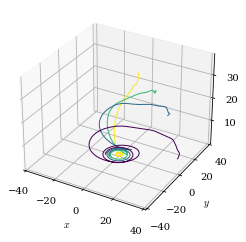

In [18]:
ax = pl.axes(projection='3d')
for i,ind in enumerate(theta_midbins):
    med_dphis, med_Rs, med_zs = [np.nanmedian(val[:,theta_inds[i]],axis=1) for val in (dphis,Rs,zs)]    
    med_ind = int(np.median(tSF_ind[theta_inds[i]]))
    _xs = med_Rs[med_ind:]*np.cos(med_dphis[med_ind:])
    _ys = med_Rs[med_ind:]*np.sin(med_dphis[med_ind:])
    _zs = med_zs[med_ind:]
    ax.plot3D(_xs,_ys,_zs,label=labels[i],c=colors[i],lw=1)
ax.set_ylim(-40,40)
ax.set_xlim(-40,40)
pl.xlabel(r'$x$')
pl.ylabel(r'$y$')
ax.zaxis.set_label('$z$')

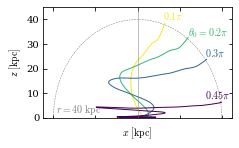

In [20]:
rCircle = 40 
fig = pl.figure(figsize=(fig_width_half,fig_width_half*0.6))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
for i,ind in enumerate(theta_midbins):
    med_dphis, med_Rs, med_zs = [np.nanmedian(val[:,theta_inds[i]],axis=1) for val in (dphis,Rs,zs)]    
    med_ind = int(np.median(tSF_ind[theta_inds[i]]))
    pl.plot(med_Rs[med_ind:]*np.cos(med_dphis[med_ind:]),med_zs[med_ind:],label=labels[i],c=colors[i],lw=1)

ax.add_artist(patches.Circle((0, 0), rCircle,facecolor='none',edgecolor='.5',lw=0.5,ls='--'))
pl.text(-39,2,r'$r=40\ {\rm kpc}$',color='.5')
i=0; pl.text(12,40,labels_short[i],color=colors[i])
i=1; pl.text(24,33,labels[i],color=colors[i])
i=2; pl.text(32,25,labels_short[i],color=colors[i])
i=3; pl.text(32,8,labels_short[i],color=colors[i])
pl.ylim(0,45)
pl.xlim(-45,45)
pl.axvline(0,c='.5',lw=.5)
pl.ylabel(r'$z\ [{\rm kpc}]$')
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.xlabel(r'$x\ [{\rm kpc}]$')
pl.savefig('helix.pdf',bbox_inches='tight')
# ax = fig.add_subplot(gs[2:, 0])
# for i,ind in enumerate(theta_midbins):
#     med_dphis, med_Rs, med_zs = [np.nanmedian(val[:,theta_inds[i]],axis=1) for val in (dphis,Rs,zs)]    
#     med_ind = int(np.median(tSF_ind[theta_inds[i]]))
#     pl.plot((med_Rs*np.cos(med_dphis))[med_ind:],(med_Rs*np.sin(med_dphis))[med_ind:],label=labels[i],c=colors[i],lw=0.75)
# ax.add_artist(patches.Circle((0, 0), rCircle,facecolor='none',edgecolor='.5',lw=0.5,ls='--'))
# pl.ylim(-45,45)
# pl.xlim(-45,45)
# pl.ylabel(r'$y\ [{\rm kpc}]$')

In [21]:
[np.percentile(tcools[-1,:],p) for p in (16,50,84)]

[3374.2333782223473, 3929.594426346221, 4904.418607527713]

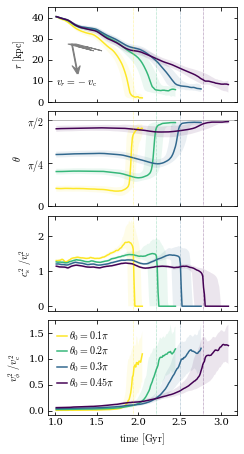

In [23]:
pl.figure(figsize=(fig_width_half,7.5)); pl.subplots_adjust(hspace=0.1)
ax = pl.subplot(411)
med_and_std(rs)
pl.ylabel(r'$r\ [{\rm kpc}]$')
pl.ylim(0,45)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.arrow(1.2,27.5,0.05,-(0.05*un.Gyr*200*un.km/un.s).to('kpc').value,
         color='.5',width=0.01,head_width=0.1,head_length=2,overhang=2)
vcool = (40.5*un.kpc/(np.median(tcools[-1,:])*un.Myr)).to('km/s')
pl.arrow(1.2,27.5,0.12,-(0.12*un.Gyr*vcool).to('kpc').value,
         color='.5',width=0.1,head_width=0.1,head_length=1,overhang=2)
pl.text(1.25,8,r'$v_r=-v_{\rm c}$',ha='center')
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
[pl.axvline(np.nanmedian(t105[theta_inds[i]])/1000,c=colors[i],lw=0.5,ls=':') for i,ind in enumerate(theta_midbins)]        


ax =pl.subplot(412)
med_and_std(thetas)
pl.ylabel(r'$\theta$')
pl.ylim(0,0.55*np.pi)
pl.axhline(0.5*np.pi,c='.5',lw=0.5)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.yaxis.set_major_locator(ticker.FixedLocator([0,np.pi/2,np.pi/4]))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(['0',r'$\pi/2$',r'$\pi/4$']))
[pl.axvline(np.nanmedian(t105[theta_inds[i]])/1000,c=colors[i],lw=0.5,ls=':') for i,ind in enumerate(theta_midbins)]        


ax = pl.subplot(413)
med_and_std((cs/vc.value)**2)
pl.ylabel(r'$c^2_{\rm s}\ / v^2_{\rm c}$')
ax.xaxis.set_major_formatter(ticker.NullFormatter())
[pl.axvline(np.nanmedian(t105[theta_inds[i]])/1000,c=colors[i],lw=0.5,ls=':') for i,ind in enumerate(theta_midbins)]        

ax = pl.subplot(414)
med_and_std((vphis/vc.value)**2)
pl.ylabel(r'$v^2_\phi\ / v^2_{\rm c}$')
pl.legend(loc='upper left',ncol=1,frameon=False,labelspacing=0.2,handlelength=1,columnspacing=0.5,handletextpad=0.2)
pl.xlabel(r'${\rm time}\ [{\rm Gyr}]$')
[pl.axvline(np.nanmedian(t105[theta_inds[i]])/1000,c=colors[i],lw=0.5,ls=':') for i,ind in enumerate(theta_midbins)]        


pl.savefig('tracking_spherical_coordinates.pdf',bbox_inches='tight')

In [278]:
t105[:5]

array([2890, 2850, 2340, 2230, 2600])

In [384]:
t105_ind[15]

130

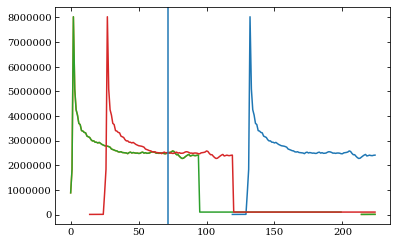

In [405]:
pl.plot(Ts[:,15])
tmp = np.roll(Ts[:,15],-130)
pl.plot(tmp)
tmp[225-130:225-25] = 1e5
pl.plot(tmp)
tmp = np.roll(tmp,25)
pl.plot(tmp)
pl.axvline(Ts.shape[0]-153)

In [394]:
Ts.shape[0]

225

In [406]:
np.roll?

In [425]:
ts_offset = -np.arange(-250,2000,10)
def shift_arr(arr,t_offset_ind=t105_ind,ts=ts):
    shifted_arr = np.zeros(arr.shape)
    for i in range(arr.shape[1]):
        shifted_arr[:,i] = np.roll(arr[:,i],-t_offset_ind[i])
        shifted_arr[225-t_offset_ind[i]:225-25,i] = -100
    return np.roll(shifted_arr, 25,axis=0)

def med_and_std_shift(all_vals,xs=ts_offset,theta_inds=theta_inds,show_std=True,ls='-'):
    for i,ind in enumerate(theta_midbins):
        vals = all_vals[:,theta_inds[i]]
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        inds = ys16>0
        pl.plot(xs[inds]/1000,ys50[inds],label=labels[i],c=colors[i],ls=ls)
        if show_std: pl.fill_between(xs[inds]/1000,ys16[inds],ys84[inds],facecolor=colors[i],alpha=0.1)    

def relative_dispersion_shift(all_vals,xs=ts_offset,theta_inds=theta_inds):
    for i,ind in enumerate(theta_midbins):        
        vals = all_vals[:,theta_inds[i]]
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        inds = ys16>0
        pl.plot(xs[inds]/1000,(ys84-ys16)[inds]/2/ys50[inds],label=labels[i],c=colors[i])

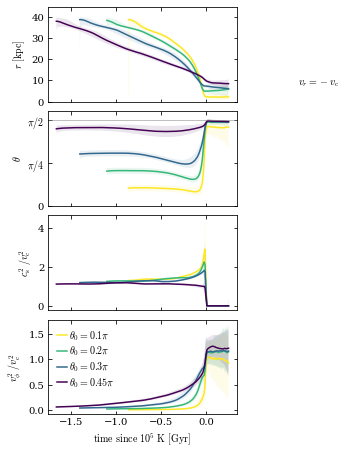

In [430]:
pl.figure(figsize=(fig_width_half,7.5)); pl.subplots_adjust(hspace=0.1)
ax = pl.subplot(411)
med_and_std_shift(shift_arr(rs))
pl.ylabel(r'$r\ [{\rm kpc}]$')
pl.ylim(0,45)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.arrow(1.2,27.5,0.05,-(0.05*un.Gyr*200*un.km/un.s).to('kpc').value,color='.5',width=0.01,head_width=0.1,head_length=2,overhang=2)
pl.text(1.25,8,r'$v_r=-v_{\rm c}$',ha='center')
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax =pl.subplot(412)
med_and_std_shift(shift_arr(thetas),xs=ts_offset)
pl.ylabel(r'$\theta$')
pl.ylim(0,0.55*np.pi)
pl.axhline(0.5*np.pi,c='.5',lw=0.5)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.yaxis.set_major_locator(ticker.FixedLocator([0,np.pi/2,np.pi/4]))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(['0',r'$\pi/2$',r'$\pi/4$']))
ax = pl.subplot(413)
med_and_std_shift(shift_arr((cs/vc.value)**2),xs=ts_offset)
pl.ylabel(r'$c^2_{\rm s}\ / v^2_{\rm c}$')
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax = pl.subplot(414)
med_and_std_shift(shift_arr((vphis/vc.value)**2),xs=ts_offset)
pl.ylabel(r'$v^2_\phi\ / v^2_{\rm c}$')
pl.legend(loc='upper left',ncol=1,frameon=False,labelspacing=0.2,handlelength=1,columnspacing=0.5,handletextpad=0.2)
pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
pl.savefig('tracking_spherical_coordinates_vs_t105.pdf',bbox_inches='tight')

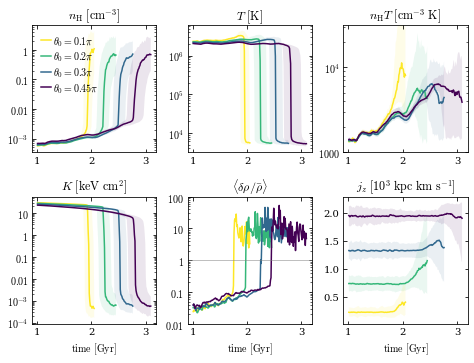

In [427]:
pl.figure(figsize=(fig_width_full*1.1,5.5)); pl.subplots_adjust(hspace=0.35,wspace=0.25)
ax = pl.subplot(231)
med_and_std(nHs)
pl.title(r'$n_{\rm H}\ [{\rm cm}^{-3}]$')
pl.legend(loc='upper left',ncol=1,frameon=False,labelspacing=0.2,handlelength=1,columnspacing=0.5,handletextpad=0.2)
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
ax = pl.subplot(232)
med_and_std(Ts)
pl.title(r'$T\ [{\rm K}]$')
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
ax = pl.subplot(233)
med_and_std(nHTs)
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.title(r'$n_{\rm H} T\ [{\rm cm}^{-3}\ {\rm K}]$')
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.ylim(1e3,10**4.5)
ax = pl.subplot(234)
med_and_std(Ks)
pl.title(r'$K\ [{\rm keV}\ {\rm cm}^2]$')
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.xlabel(r'${\rm time}\ [{\rm Gyr}]$')
ax = pl.subplot(235)
relative_dispersion(nHs)
pl.semilogy()
pl.title(r'$\langle\delta \rho/\bar \rho\rangle$')
ax.yaxis.set_major_formatter(u.arilogformatter)
pl.ylim(0.01,100)
pl.axhline(1,c='.5',lw=0.5)
pl.xlabel(r'${\rm time}\ [{\rm Gyr}]$')
ax = pl.subplot(236)
med_and_std(jzs/1000)
pl.title(r'$j_z\ [10^3\ {\rm kpc}\ {\rm km}\ {\rm s}^{-1}]$')
pl.xlabel(r'${\rm time}\ [{\rm Gyr}]$')

pl.savefig('tracking_properties.pdf',bbox_inches='tight')

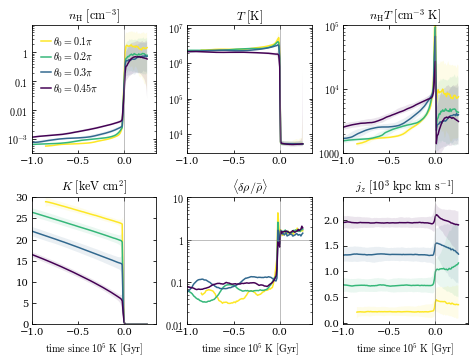

In [486]:
xls = -1.,0.35
pl.figure(figsize=(fig_width_full*1.1,5.5)); pl.subplots_adjust(hspace=0.35,wspace=0.25)
ax = pl.subplot(231)
med_and_std_shift(shift_arr(nHs))
pl.title(r'$n_{\rm H}\ [{\rm cm}^{-3}]$')
pl.legend(loc='upper left',ncol=1,frameon=False,labelspacing=0.2,handlelength=1,columnspacing=0.5,handletextpad=0.2)
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)
ax = pl.subplot(232)
med_and_std_shift(shift_arr(Ts))
pl.title(r'$T\ [{\rm K}]$')
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)
ax = pl.subplot(233)
med_and_std_shift(shift_arr(nHTs))
pl.title(r'$n_{\rm H} T\ [{\rm cm}^{-3}\ {\rm K}]$')
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
pl.ylim(1e3,1e5)
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)
ax = pl.subplot(234)
med_and_std_shift(shift_arr(Ks))
pl.title(r'$K\ [{\rm keV}\ {\rm cm}^2]$')
pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
pl.ylim(0,30)
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)
ax = pl.subplot(235)
relative_dispersion_shift(shift_arr(nHs))
pl.semilogy()
pl.title(r'$\langle\delta \rho/\bar \rho\rangle$')
ax.yaxis.set_major_formatter(u.arilogformatter)
pl.ylim(0.01,10)
pl.axhline(1,c='.5',lw=0.5)
pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)
ax = pl.subplot(236)
med_and_std_shift(shift_arr(jzs)/1000)
pl.title(r'$j_z\ [10^3\ {\rm kpc}\ {\rm km}\ {\rm s}^{-1}]$')
pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
pl.axvline(0,c='.5',lw=0.5)
pl.xlim(*xls)
pl.savefig('tracking_properties_vs_t105.pdf',bbox_inches='tight')

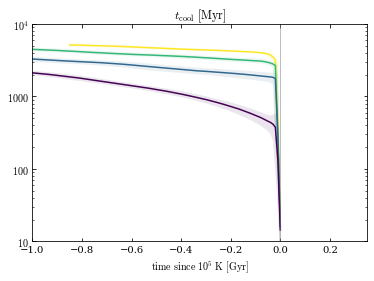

In [490]:
ax=pl.subplot(111)
med_and_std_shift(shift_arr(tcools))
pl.title(r'$t_{\rm cool}\ [{\rm Myr}]$')
pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.ylim(10,10000)
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)

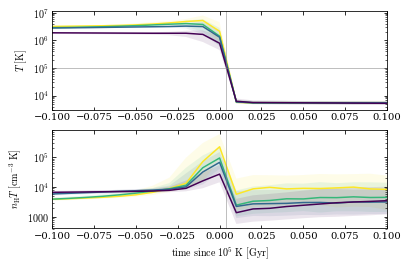

In [497]:
xls = -0.1,0.1
ax=pl.subplot(211)
med_and_std_shift(shift_arr(Ts))
pl.ylabel(r'$T\ [{\rm K}]$')
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.xlim(*xls)
pl.axvline(0.004,c='.5',lw=0.5)
pl.axhline(1e5,c='.5',lw=0.5)
ax = pl.subplot(212)
med_and_std_shift(shift_arr(nHTs))
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.ylabel(r'$n_{\rm H} T\ [{\rm cm}^{-3}\ {\rm K}]$')
pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
pl.xlim(*xls)
pl.axvline(0.004,c='.5',lw=0.5)

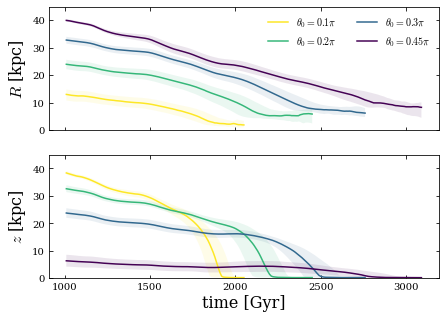

In [180]:
pl.figure(figsize=(7,5))
ax = pl.subplot(211)
med_and_std(Rs)
pl.ylabel(r'$R$ [kpc]',fontsize=16)
pl.legend(loc='upper right',ncol=2,frameon=False,labelspacing=0.5)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.ylim(0,45)
pl.subplot(212)
med_and_std(zs)
pl.ylabel(r'$z$ [kpc]',fontsize=16)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.xlabel(r'time [Gyr]',fontsize=16)
pl.ylim(0,45)
pl.savefig('tracking_cylindrical_coordinates.pdf')

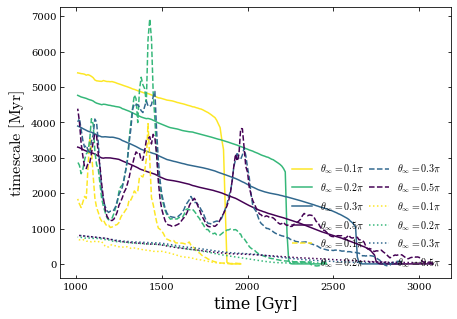

In [50]:
pl.figure(figsize=(7,5))
med_and_std(tcools,ls='-',show_std=False)
med_and_std(-tflows,ls='--',show_std=False)
med_and_std(trots,ls=':',show_std=False)
pl.ylabel(r'${\rm timescale}\ [{\rm Myr}]$',fontsize=16)
pl.legend(loc='lower right',ncol=2,frameon=False,columnspacing=0.5)
pl.xlabel(r'time [Gyr]',fontsize=16)
pl.savefig('tracking_timescale.pdf')

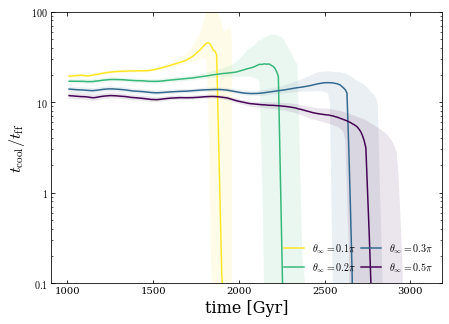

In [52]:
pl.figure(figsize=(7,5))
ax=pl.subplot(111)
med_and_std(tcools/tffs)
pl.ylabel(r'$t_{\rm cool}/t_{\rm ff}$',fontsize=16)
pl.legend(loc='lower right',ncol=2,frameon=False,columnspacing=0.5)
pl.xlabel(r'time [Gyr]',fontsize=16)
pl.semilogy()
pl.ylim(0.1,100)
ax.yaxis.set_major_formatter(u.arilogformatter)
pl.savefig('tracking_tcool_to_tff.pdf')

In [55]:
(2**0.5*10*un.kpc/(200*un.km/un.s)).to('Myr')

<Quantity 69.14035105 Myr>

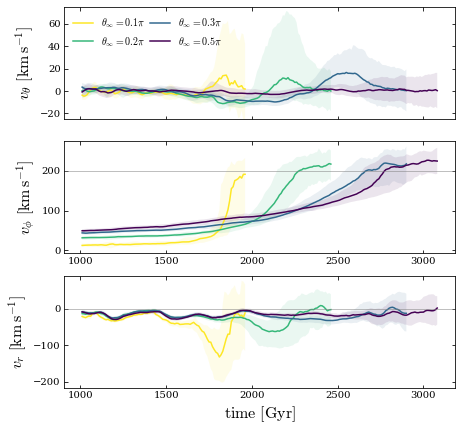

In [134]:
pl.figure(figsize=(7,7))
ax = pl.subplot(311)
med_and_std(vthetas)
pl.ylabel(r'$v_\theta\ [{\rm km}\,{\rm s}^{-1}]$',fontsize=16)
pl.legend(loc='upper left',ncol=2,frameon=False,columnspacing=0.5)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.ylim(-25,75)
pl.subplot(312)
med_and_std(vphis)
pl.ylabel(r'$v_\phi\ [{\rm km}\,{\rm s}^{-1}]$',fontsize=16)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.axhline(200,c='.5',lw=0.5)
pl.subplot(313)
med_and_std(vrs)
pl.ylabel(r'$v_r\ [{\rm km}\,{\rm s}^{-1}]$',fontsize=16)
pl.xlabel(r'${\rm time}\ [{\rm Gyr}]$',fontsize=16)
pl.axhline(0,c='.5',lw=0.5)
pl.savefig('tracking_velocity.pdf')

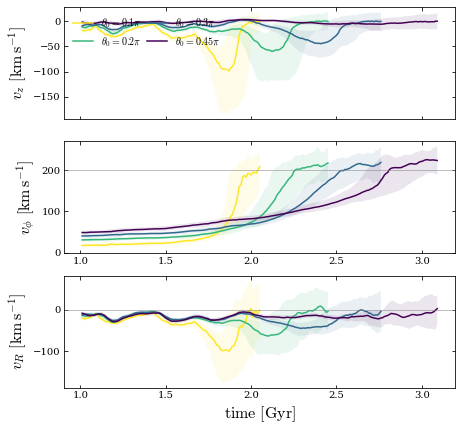

In [436]:
pl.figure(figsize=(7,7))
ax = pl.subplot(311)
med_and_std(vzs)
pl.ylabel(r'$v_z\ [{\rm km}\,{\rm s}^{-1}]$',fontsize=16)
pl.legend(loc='upper left',ncol=2,frameon=False,columnspacing=0.5)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
# pl.ylim(-25,75)
pl.subplot(312)
med_and_std(vphis)
pl.ylabel(r'$v_\phi\ [{\rm km}\,{\rm s}^{-1}]$',fontsize=16)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.axhline(200,c='.5',lw=0.5)
pl.subplot(313)
med_and_std(vrs)
pl.ylabel(r'$v_R\ [{\rm km}\,{\rm s}^{-1}]$',fontsize=16)
pl.xlabel(r'${\rm time}\ [{\rm Gyr}]$',fontsize=16)
pl.axhline(0,c='.5',lw=0.5)
pl.savefig('tracking_velocity_cylindrical.pdf')

(1000000.0, 5000000.0)

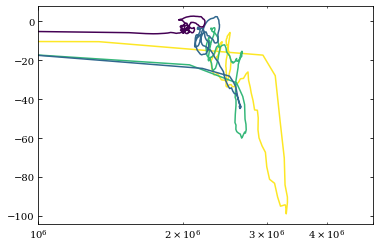

In [446]:
for i,inds in enumerate(theta_inds):
    pl.plot(np.nanmedian(Ts[:,inds],axis=1),
            np.nanmedian(vzs[:,inds],axis=1),
           c=colors[i],label=labels[i])
pl.semilogx()
pl.xlim(1e6,5e6)

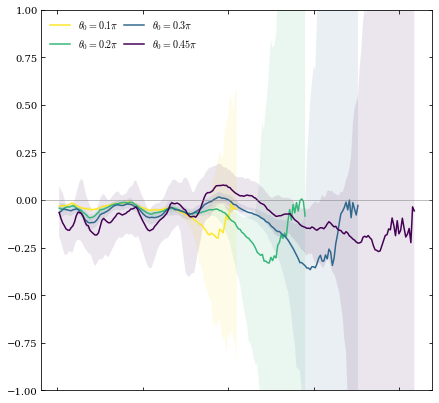

In [439]:
pl.figure(figsize=(7,7))
ax = pl.subplot(111)
# g = vc^2/r * z/R ~ vc^2 z / R^2
# gz = vc^2 z^2 / R^2
# vc_eff = vc*z/R
med_and_std(vzs/(200 * zs/Rs))
# pl.ylabel(r'$v_z\ [{\rm km}\,{\rm s}^{-1}]$',fontsize=16)
pl.legend(loc='upper left',ncol=2,frameon=False,columnspacing=0.5)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.ylim(-1,1)
pl.axhline(0,c='.5',lw=0.5)
# pl.savefig('tracking_velocity_cylindrical.pdf')

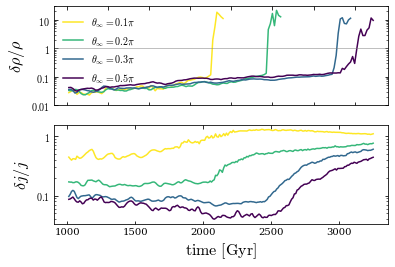

In [66]:
relative_dispersion(jzs)
pl.semilogy()
pl.ylabel(r'$\delta j/j$',fontsize=16)
pl.xlabel(r'${\rm time}\ [{\rm Gyr}]$',fontsize=16)
ax.yaxis.set_major_formatter(u.arilogformatter)
pl.savefig('tracking_dispersion.pdf')

/home/ysz5546/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


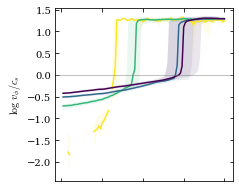

In [227]:
pl.figure(figsize=(7,7))
ax = pl.subplot(221)
med_and_std(log(vphis/cs))
pl.ylabel(r'$\log\ v_\phi/c_s$')
ax.xaxis.set_major_formatter(ticker.NullFormatter())
pl.axhline(0,lw=0.5,c='.5')
# ax = pl.subplot(222)
# med_and_std(log(nHs))
# pl.ylabel(r'$\log\ n_{\rm H}$')
# pl.legend(loc='upper left',ncol=2,frameon=False,columnspacing=0.5)
# ax.xaxis.set_major_formatter(ticker.NullFormatter())
# pl.subplot(223)
# med_and_std(log(nHTs))
# pl.ylabel(r'$\log\ n_{\rm H} T$')
# pl.xlabel(r'time [Gyr]')
# pl.subplot(224)
# med_and_std(log(Ks))
# pl.ylabel(r'$\log\ K$')
# pl.xlabel(r'time [Gyr]')